In [5]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from kneed import KneeLocator
import warnings
from scipy.spatial.distance import cdist

# Ignorar avisos para manter a saída limpa
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# 1. FUNÇÕES AUXILIARES (NENHUMA MUDANÇA AQUI)
# =============================================================================

def load_and_prepare_data(file_path):
    """
    Carrega um dataset no formato .mat, onde a última coluna é o alvo (y).
    """
    try:
        mat = loadmat(file_path)
        data_key = [k for k in mat if not k.startswith('__')][0]
        data_matrix = mat[data_key]
        print(f"Dataset '{file_path}' carregado. Formato da matriz completa: {data_matrix.shape}")
        
        X = data_matrix[:, :-1]
        y = data_matrix[:, -1]

        le = LabelEncoder()
        y = le.fit_transform(y)

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        print(f"Dados preparados. Formato de X: {X.shape}, Formato de y: {y.shape}")
        return X, y, le.classes_
    
    except FileNotFoundError:
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None, None, None
    except IndexError:
        print(f"Erro: Não foi possível encontrar a matriz de dados no arquivo '{file_path}'. Verifique o conteúdo do arquivo.")
        return None, None, None

def find_optimal_k(data, max_k=10):
    """
    Usa o método do Cotovelo (Elbow Method) para encontrar o número ideal de clusters.
    """
    if len(data) < max_k:
        max_k = len(data)
    
    if max_k <= 1:
        return 1

    inertias = []
    k_range = range(1, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    try:
        kneedle = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
        return kneedle.elbow if kneedle.elbow else 2
    except:
        return 2

# =============================================================================
# 2. CLASSES DOS CLASSIFICADORES (COM AS ALTERAÇÕES)
# =============================================================================

class KMeansClassifier:
    """Classificador baseado em centróides do K-Means para cada classe."""
    def __init__(self):
        self.centroids_ = []
        self.centroid_labels_ = []
        self.k_per_class_ = {} # <-- NOVA LINHA

    def fit(self, X_train, y_train):
        self.centroids_ = []
        self.centroid_labels_ = []
        self.k_per_class_ = {} # <-- NOVA LINHA
        unique_classes = np.unique(y_train)

        for c in unique_classes:
            X_class = X_train[y_train == c]
            if len(X_class) > 0:
                optimal_k = find_optimal_k(X_class)
                self.k_per_class_[c] = optimal_k # <-- NOVA LINHA
                
                kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(X_class)
                self.centroids_.extend(kmeans.cluster_centers_)
                self.centroid_labels_.extend([c] * optimal_k)
        return self

    def predict(self, X_test):
        if not self.centroids_:
            raise RuntimeError("O classificador deve ser treinado antes da predição.")
        distances = cdist(X_test, self.centroids_)
        closest_centroid_indices = np.argmin(distances, axis=1)
        return np.array(self.centroid_labels_)[closest_centroid_indices]

class FuzzyCMeansClassifier:
    """Classificador baseado no grau de pertinência do Fuzzy C-Means."""
    def __init__(self, m=2):
        self.centroids_ = []
        self.centroid_labels_ = []
        self.m_ = m
        self.k_per_class_ = {} # <-- NOVA LINHA

    def fit(self, X_train, y_train):
        self.centroids_ = []
        self.centroid_labels_ = []
        self.k_per_class_ = {} # <-- NOVA LINHA
        unique_classes = np.unique(y_train)

        for c in unique_classes:
            X_class = X_train[y_train == c]
            if len(X_class) > 1:
                optimal_k = find_optimal_k(X_class)
                self.k_per_class_[c] = optimal_k # <-- NOVA LINHA

                cntr, _, _, _, _, _, _ = fuzz.cluster.cmeans(
                    X_class.T, c=optimal_k, m=self.m_, error=0.005, maxiter=1000, init=None
                )
                self.centroids_.extend(cntr)
                self.centroid_labels_.extend([c] * optimal_k)
        return self

    def predict(self, X_test):
        if not self.centroids_:
            raise RuntimeError("O classificador deve ser treinado antes da predição.")
        u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            X_test.T, np.array(self.centroids_), self.m_, error=0.005, maxiter=1000
        )
        max_membership_indices = np.argmax(u, axis=0)
        return np.array(self.centroid_labels_)[max_membership_indices]

class GMMClassifier:
    """Classificador baseado na máxima verossimilhança de Modelos de Mistura Gaussiana."""
    def __init__(self):
        self.gmms_ = {}
        self.classes_ = []
        self.k_per_class_ = {} # <-- NOVA LINHA

    def fit(self, X_train, y_train):
        self.gmms_ = {}
        self.classes_ = np.unique(y_train)
        self.k_per_class_ = {} # <-- NOVA LINHA

        for c in self.classes_:
            X_class = X_train[y_train == c]
            if len(X_class) > 1:
                optimal_k = find_optimal_k(X_class)
                self.k_per_class_[c] = optimal_k # <-- NOVA LINHA
                
                gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(X_class)
                self.gmms_[c] = gmm
        return self

    def predict(self, X_test):
        if not self.gmms_:
            raise RuntimeError("O classificador deve ser treinado antes da predição.")
        log_likelihoods = np.array([self.gmms_[c].score_samples(X_test) for c in self.classes_])
        return self.classes_[np.argmax(log_likelihoods, axis=0)]

# =============================================================================
# 3. FUNÇÃO PRINCIPAL DO EXPERIMENTO (ATUALIZADA)
# =============================================================================

def run_experiment(classifier_class, dataset_path, n_repetitions=30):
    """
    Executa o experimento completo para um dado classificador e dataset.
    """
    X, y, original_classes = load_and_prepare_data(dataset_path)
    if X is None:
        return

    accuracies = []
    
    print(f"\n--- Iniciando Experimento: {classifier_class.__name__} no Dataset: {dataset_path} ---")

    for i in range(n_repetitions):
        seed = i + 1
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=seed, stratify=y, shuffle=True
        )
        classifier = classifier_class()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
        if (i + 1) % 5 == 0 or i == n_repetitions - 1:
            print(f"Repetição {i + 1}/{n_repetitions}: Acurácia = {acc:.4f}")

    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)
    
    print("\n--- Resultados Finais ---")
    print(f"Acurácia Média ({n_repetitions} repetições): {mean_accuracy:.4f}")
    print(f"Desvio Padrão da Acurácia: {std_dev_accuracy:.4f}")

    print("\nMatriz de Confusão (da última repetição):")
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(original_classes)))
    cm_df = pd.DataFrame(cm, index=original_classes, columns=original_classes)
    print(cm_df)

    # --- BLOCO NOVO PARA EXIBIR O NÚMERO DE CLUSTERS ---
    print("\nNúmero de Clusters Usado por Classe (na última repetição):")
    if hasattr(classifier, 'k_per_class_'):
        for class_idx, k_value in sorted(classifier.k_per_class_.items()):
            class_name = original_classes[class_idx]
            print(f"  - Classe '{class_name}': {k_value} clusters")
    print("--------------------------------------------------\n")

# =============================================================================
# 4. EXECUÇÃO DOS EXPERIMENTOS (NENHUMA MUDANÇA AQUI)
# =============================================================================

# Coloque o caminho para seus arquivos .mat aqui
ADULT_DATASET_PATH = 'Adult.mat' 
DRYBEAN_DATASET_PATH = 'Dry_bean.mat'

# Lista de classificadores a serem testados
classifiers_to_test = [KMeansClassifier, FuzzyCMeansClassifier, GMMClassifier]

# Executa para o dataset Adult
print("#############################################")
print("### INICIANDO ANÁLISE PARA O DATASET ADULT ###")
print("#############################################")
for clf in classifiers_to_test:
    run_experiment(clf, ADULT_DATASET_PATH)

# Executa para o dataset DryBean
print("\n#################################################")
print("### INICIANDO ANÁLISE PARA O DATASET DRY BEAN ###")
print("#################################################")
for clf in classifiers_to_test:
    run_experiment(clf, DRYBEAN_DATASET_PATH)

#############################################
### INICIANDO ANÁLISE PARA O DATASET ADULT ###
#############################################
Dataset 'Adult.mat' carregado. Formato da matriz completa: (30162, 13)
Dados preparados. Formato de X: (30162, 12), Formato de y: (30162,)

--- Iniciando Experimento: KMeansClassifier no Dataset: Adult.mat ---
Repetição 5/30: Acurácia = 0.3982
Repetição 10/30: Acurácia = 0.3641
Repetição 15/30: Acurácia = 0.3373
Repetição 20/30: Acurácia = 0.6656
Repetição 25/30: Acurácia = 0.6252
Repetição 30/30: Acurácia = 0.6522

--- Resultados Finais ---
Acurácia Média (30 repetições): 0.5255
Desvio Padrão da Acurácia: 0.0996

Matriz de Confusão (da última repetição):
      0.0   1.0
0.0  5440  1438
1.0  1709   462

Número de Clusters Usado por Classe (na última repetição):
  - Classe '0.0': 6 clusters
  - Classe '1.0': 4 clusters
--------------------------------------------------

Dataset 'Adult.mat' carregado. Formato da matriz completa: (30162, 13)
Dados prep

Gerando e salvando gráficos para o Dataset Adult...
Gráfico salvo como: matriz_adult_kmeans.png


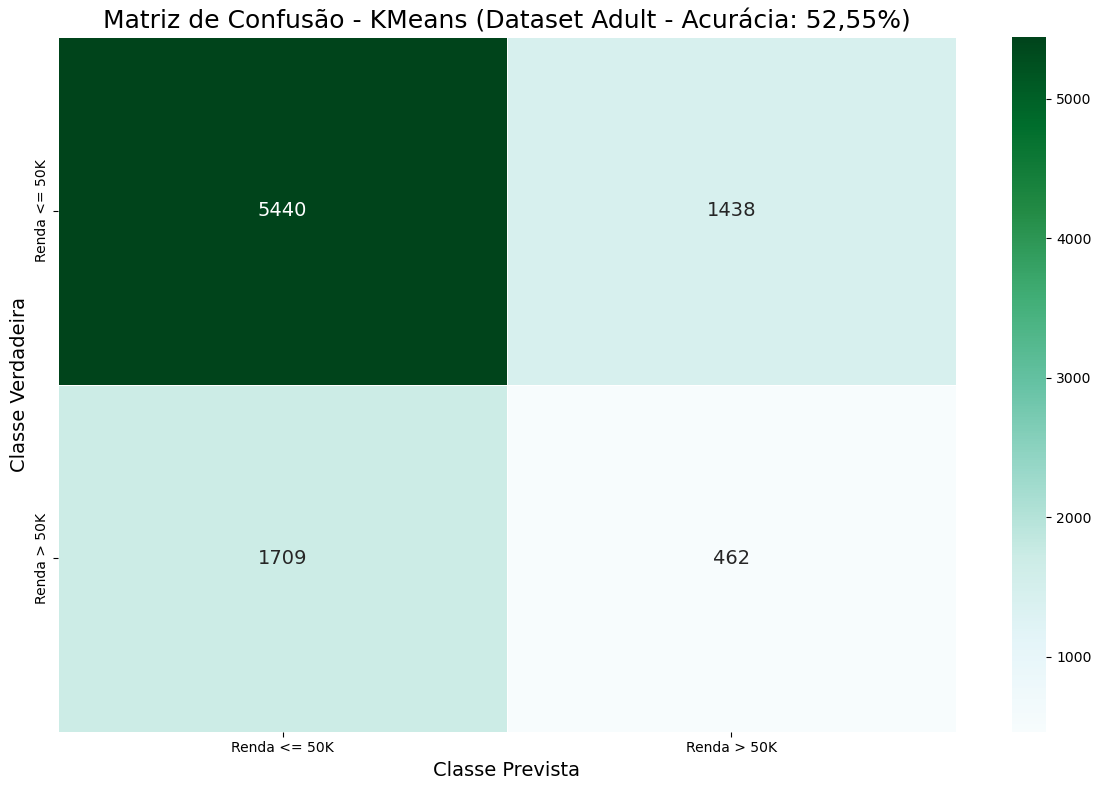

Gráfico salvo como: matriz_adult_fcm.png


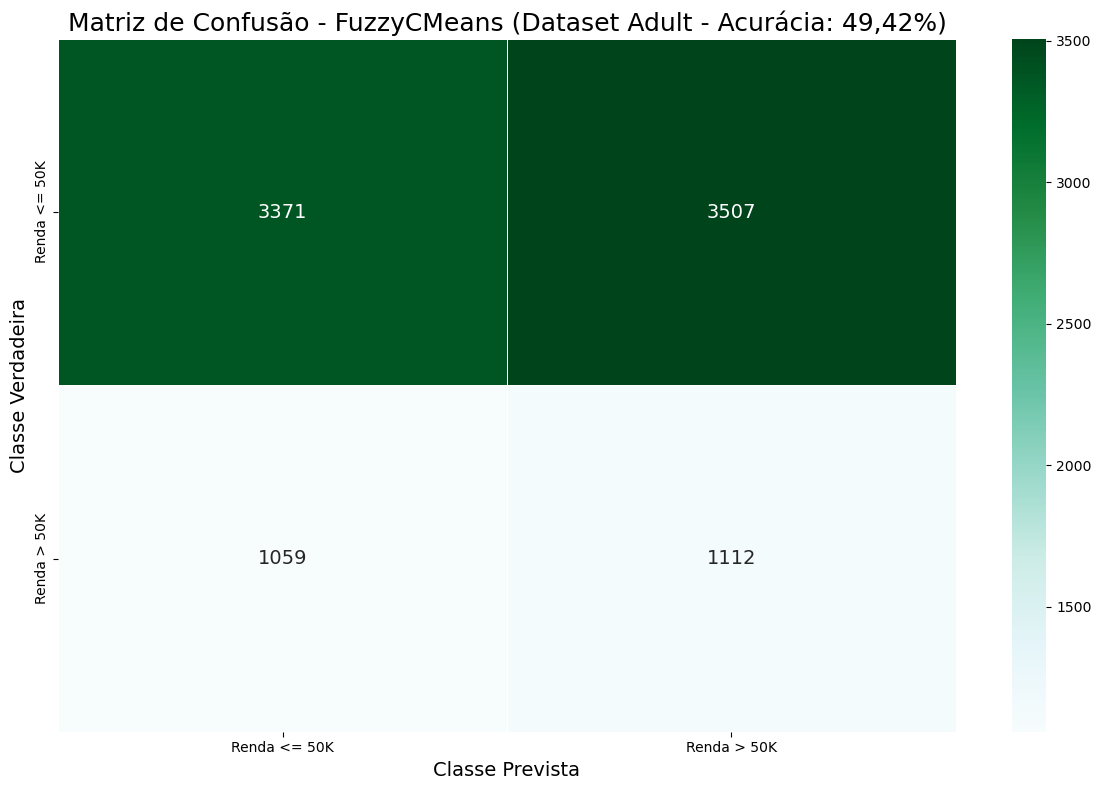

Gráfico salvo como: matriz_adult_gmm.png


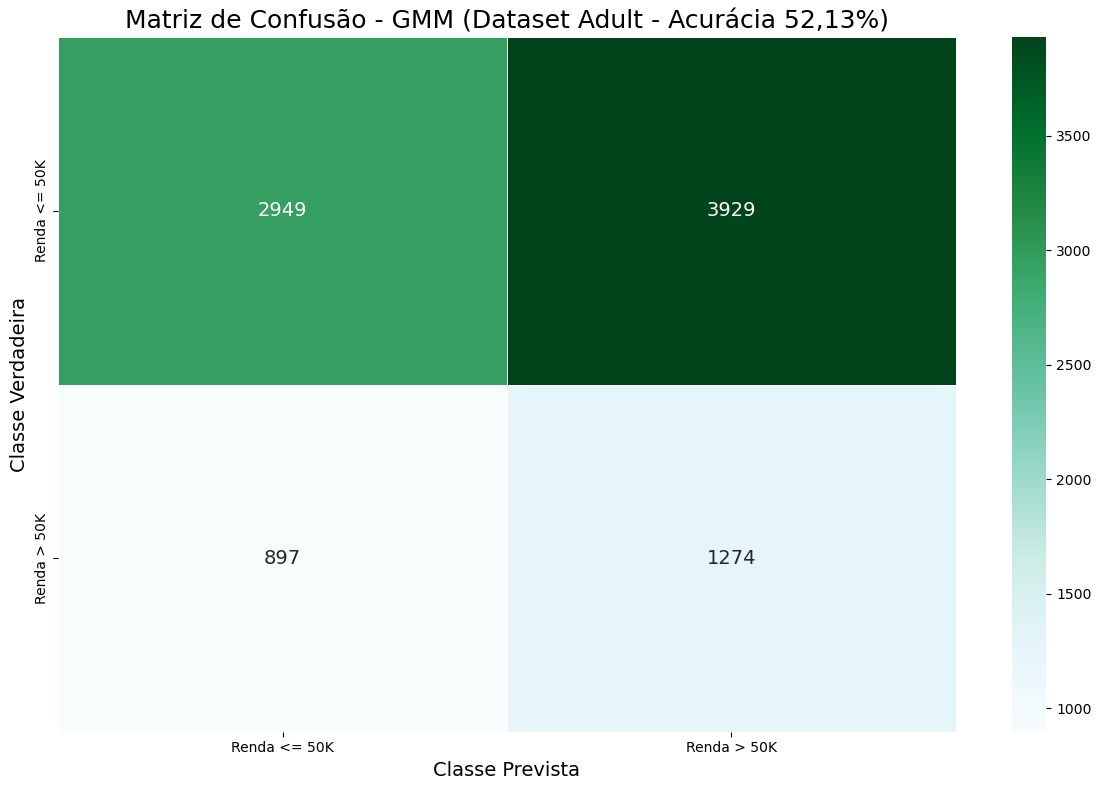


Gerando e salvando gráficos para o Dataset Dry Bean...
Gráfico salvo como: matriz_drybean_kmeans.png


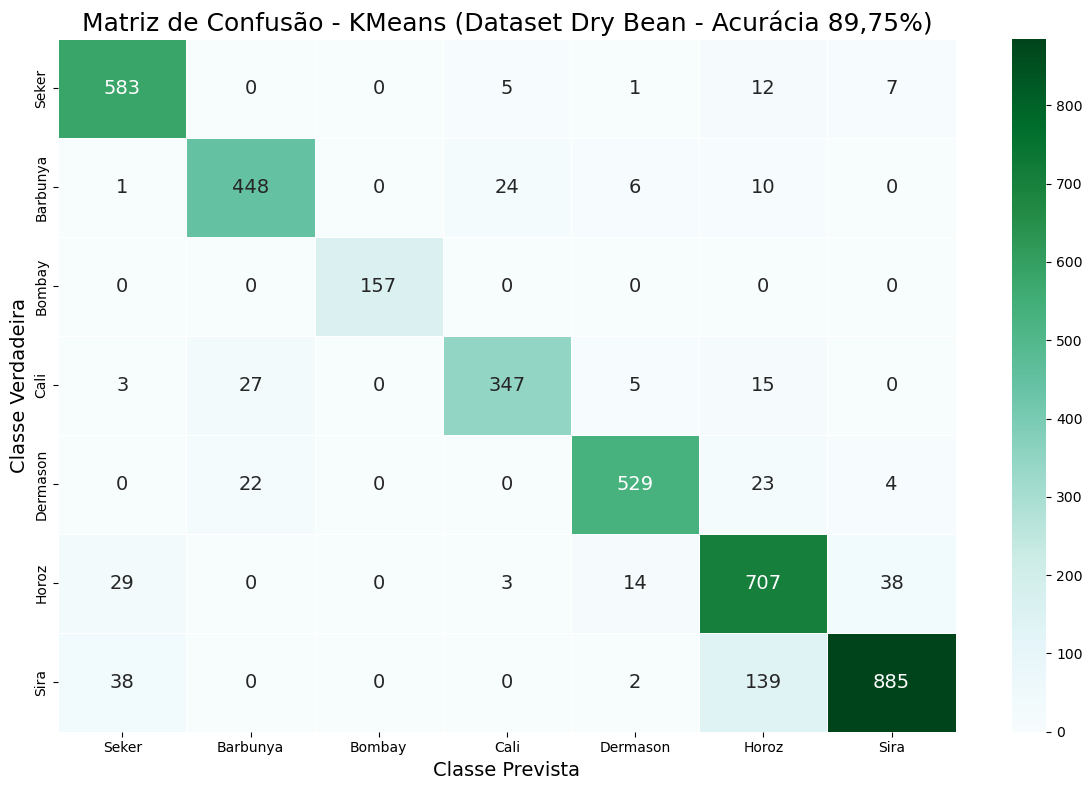

Gráfico salvo como: matriz_drybean_fcm.png


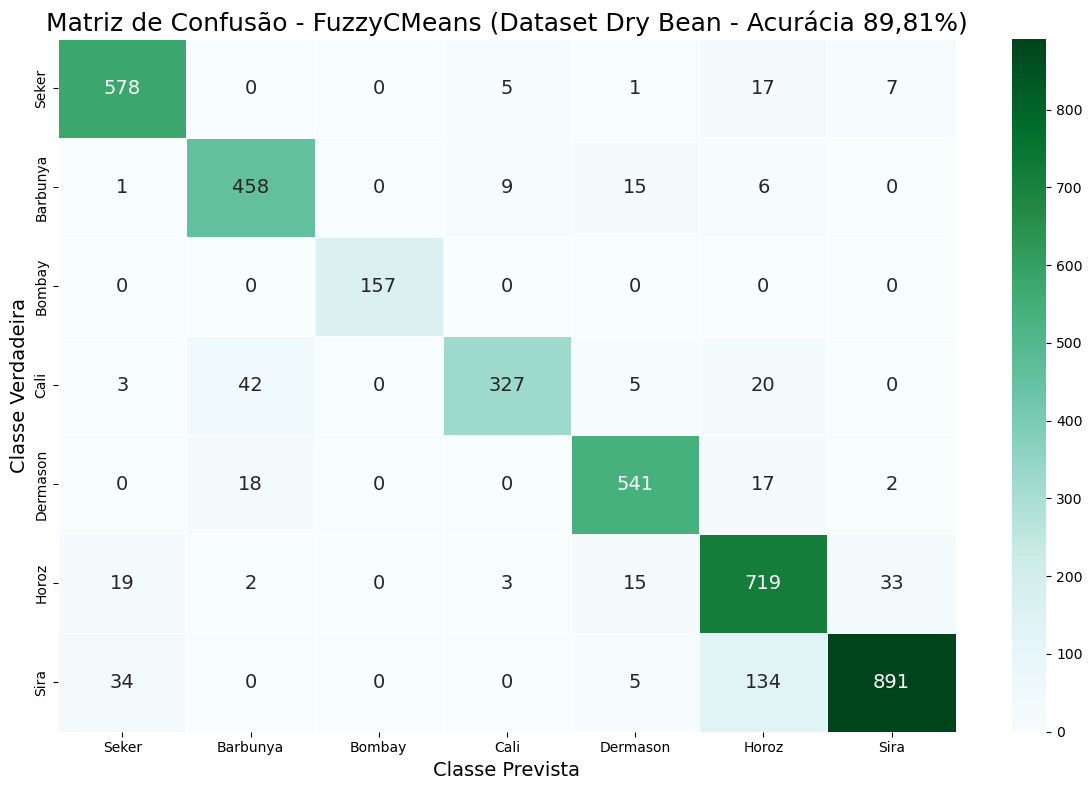

Gráfico salvo como: matriz_drybean_gmm.png


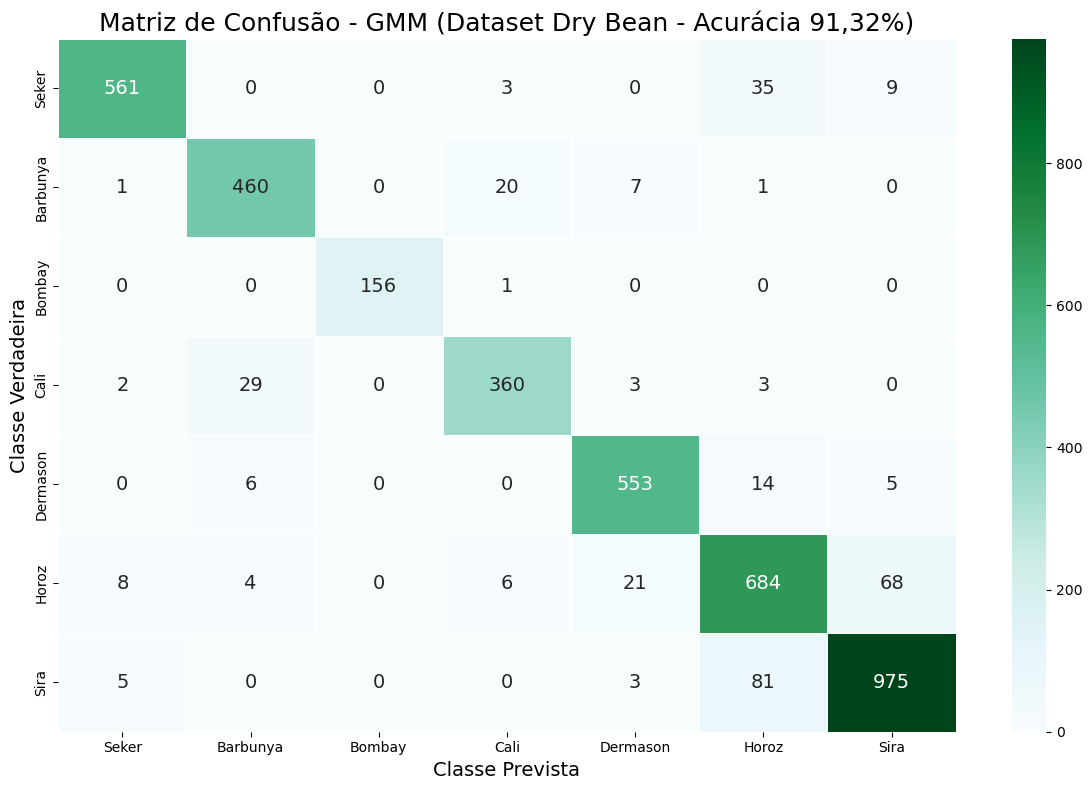


Processo finalizado. Todos os gráficos foram salvos na pasta.


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --------------------------------------------------------------------------
# Função para plotar a matriz (MODIFICADA PARA SALVAR O ARQUIVO)
# --------------------------------------------------------------------------
def plotar_matriz_confusao(cm, classes, titulo, nome_arquivo):
    """
    Esta função plota a matriz de confusão e a salva como um arquivo de imagem.
    cm: matriz de confusão calculada
    classes: lista com os nomes das classes
    titulo: título do gráfico
    nome_arquivo: nome do arquivo para salvar a imagem (ex: 'grafico.png')
    """
    plt.figure(figsize=(12, 8))
    
    sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), 
                annot=True,
                fmt='d',
                cmap='BuGn',
                linewidths=.5,
                annot_kws={"size": 14})

    plt.title(titulo, fontsize=18)
    plt.ylabel('Classe Verdadeira', fontsize=14)
    plt.xlabel('Classe Prevista', fontsize=14)
    plt.tight_layout()
    
    # --- Linha Chave: Salva a figura no disco ---
    # dpi=300 garante uma imagem de alta resolução.
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_arquivo}")

    # Exibe o gráfico na tela
    plt.show()

    # Fecha a figura para liberar memória
    plt.close()


# --------------------------------------------------------------------------
# DADOS DE ENTRADA EXTRAÍDOS DOS SEUS RESULTADOS
# --------------------------------------------------------------------------

### === DATASET ADULT === ###
classes_adult = ['Renda <= 50K', 'Renda > 50K']

# 1. Adult - KMeans
matriz_adult_kmeans = np.array([[5440, 1438], [1709,  462]])
titulo_adult_kmeans = 'Matriz de Confusão - KMeans (Dataset Adult - Acurácia: 52,55%)'
nome_arquivo_adult_kmeans = 'matriz_adult_kmeans.png' # Nome do arquivo

# 2. Adult - FuzzyCMeans
matriz_adult_fcm = np.array([[3371, 3507], [1059, 1112]])
titulo_adult_fcm = 'Matriz de Confusão - FuzzyCMeans (Dataset Adult - Acurácia: 49,42%)'
nome_arquivo_adult_fcm = 'matriz_adult_fcm.png' # Nome do arquivo

# 3. Adult - GMM
matriz_adult_gmm = np.array([[2949, 3929], [ 897, 1274]])
titulo_adult_gmm = 'Matriz de Confusão - GMM (Dataset Adult - Acurácia 52,13%)'
nome_arquivo_adult_gmm = 'matriz_adult_gmm.png' # Nome do arquivo


### === DATASET DRY BEAN === ###
classes_drybean = ['Seker', 'Barbunya', 'Bombay', 'Cali', 'Dermason', 'Horoz', 'Sira']

# 4. Dry Bean - KMeans
matriz_drybean_kmeans = np.array([[583, 0, 0, 5, 1, 12, 7], [1, 448, 0, 24, 6, 10, 0], [0, 0, 157, 0, 0, 0, 0], [3, 27, 0, 347, 5, 15, 0], [0, 22, 0, 0, 529, 23, 4], [29, 0, 0, 3, 14, 707, 38], [38, 0, 0, 0, 2, 139, 885]])
titulo_drybean_kmeans = 'Matriz de Confusão - KMeans (Dataset Dry Bean - Acurácia 89,75%)'
nome_arquivo_drybean_kmeans = 'matriz_drybean_kmeans.png' # Nome do arquivo

# 5. Dry Bean - FuzzyCMeans
matriz_drybean_fcm = np.array([[578, 0, 0, 5, 1, 17, 7], [1, 458, 0, 9, 15, 6, 0], [0, 0, 157, 0, 0, 0, 0], [3, 42, 0, 327, 5, 20, 0], [0, 18, 0, 0, 541, 17, 2], [19, 2, 0, 3, 15, 719, 33], [34, 0, 0, 0, 5, 134, 891]])
titulo_drybean_fcm = 'Matriz de Confusão - FuzzyCMeans (Dataset Dry Bean - Acurácia 89,81%)'
nome_arquivo_drybean_fcm = 'matriz_drybean_fcm.png' # Nome do arquivo

# 6. Dry Bean - GMM
matriz_drybean_gmm = np.array([[561, 0, 0, 3, 0, 35, 9], [1, 460, 0, 20, 7, 1, 0], [0, 0, 156, 1, 0, 0, 0], [2, 29, 0, 360, 3, 3, 0], [0, 6, 0, 0, 553, 14, 5], [8, 4, 0, 6, 21, 684, 68], [5, 0, 0, 0, 3, 81, 975]])
titulo_drybean_gmm = 'Matriz de Confusão - GMM (Dataset Dry Bean - Acurácia 91,32%)'
nome_arquivo_drybean_gmm = 'matriz_drybean_gmm.png' # Nome do arquivo


# --------------------------------------------------------------------------
# Chamada das funções para gerar e SALVAR cada gráfico
# --------------------------------------------------------------------------

print("Gerando e salvando gráficos para o Dataset Adult...")
plotar_matriz_confusao(matriz_adult_kmeans, classes_adult, titulo_adult_kmeans, nome_arquivo_adult_kmeans)
plotar_matriz_confusao(matriz_adult_fcm, classes_adult, titulo_adult_fcm, nome_arquivo_adult_fcm)
plotar_matriz_confusao(matriz_adult_gmm, classes_adult, titulo_adult_gmm, nome_arquivo_adult_gmm)

print("\nGerando e salvando gráficos para o Dataset Dry Bean...")
plotar_matriz_confusao(matriz_drybean_kmeans, classes_drybean, titulo_drybean_kmeans, nome_arquivo_drybean_kmeans)
plotar_matriz_confusao(matriz_drybean_fcm, classes_drybean, titulo_drybean_fcm, nome_arquivo_drybean_fcm)
plotar_matriz_confusao(matriz_drybean_gmm, classes_drybean, titulo_drybean_gmm, nome_arquivo_drybean_gmm)

print("\nProcesso finalizado. Todos os gráficos foram salvos na pasta.")

In [3]:
# 1. Importa as bibliotecas necessárias
import pandas as pd
from scipy.io import loadmat
import numpy as np

# 2. Defina os nomes dos arquivos de entrada e saída
arquivo_mat_entrada = 'Dry_bean.mat'
arquivo_xlsx_saida = 'Bean_convertido.xlsx'

try:
    # --- PASSO 1: LER O ARQUIVO .MAT ---
    print(f"Lendo o arquivo '{arquivo_mat_entrada}'...")
    dados_mat = loadmat(arquivo_mat_entrada)

    # Encontra o nome da variável principal dentro do arquivo
    nome_da_variavel = [k for k in dados_mat if not k.startswith('__')][0]
    matriz_de_dados = dados_mat[nome_da_variavel]
    print("Leitura concluída.")

    # --- PASSO 2: CONVERTER PARA UMA TABELA (DATAFRAME) ---
    print("Convertendo para o formato de tabela...")
    # Cria nomes genéricos para as colunas
    nomes_das_colunas = [f'Variavel_{i+1}' for i in range(matriz_de_dados.shape[1] - 1)]
    nomes_das_colunas.append('Classe')

    # Cria o DataFrame
    df = pd.DataFrame(data=matriz_de_dados, columns=nomes_das_colunas)
    print("Conversão concluída.")

    # --- PASSO 3: SALVAR A TABELA EM UM ARQUIVO EXCEL ---
    print(f"Salvando os dados no arquivo '{arquivo_xlsx_saida}'...")
    # Usa a função to_excel para salvar.
    # O parâmetro 'index=False' evita que o índice do pandas (0, 1, 2...)
    # seja salvo como uma coluna extra no Excel.
    df.to_excel(arquivo_xlsx_saida, index=False)
    
    print("\nProcesso finalizado com sucesso!")
    print(f"O arquivo '{arquivo_xlsx_saida}' foi criado na mesma pasta do código.")

except FileNotFoundError:
    print(f"Erro: O arquivo de entrada '{arquivo_mat_entrada}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Lendo o arquivo 'Dry_bean.mat'...
Leitura concluída.
Convertendo para o formato de tabela...
Conversão concluída.
Salvando os dados no arquivo 'Bean_convertido.xlsx'...

Processo finalizado com sucesso!
O arquivo 'Bean_convertido.xlsx' foi criado na mesma pasta do código.


In [11]:
# Importações adicionais para o novo pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# As outras importações permanecem as mesmas
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from kneed import KneeLocator
import warnings
from scipy.spatial.distance import cdist

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# 1. FUNÇÃO DE PRÉ-PROCESSAMENTO (NENHUMA ALTERAÇÃO AQUI)
# =============================================================================
def load_and_process_original_adult(file_path):
    try:
        column_names = [
            'age', 'workclass', 'fnlwgt', 'education', 'education-num',
            'marital-status', 'occupation', 'relationship', 'race', 'sex',
            'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
        ]
        df = pd.read_csv(file_path, header=None, names=column_names, 
                         na_values=' ?', skipinitialspace=True)
        print("Dataset original carregado com sucesso.")
        df.dropna(inplace=True)
        print(f"Dimensões após remover nulos: {df.shape}")
        X = df.drop('income', axis=1)
        y_raw = df['income']
        le = LabelEncoder()
        y = le.fit_transform(y_raw)
        numeric_features = X.select_dtypes(include=np.number).columns.tolist()
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        print(f"Variáveis numéricas: {numeric_features}")
        print(f"Variáveis categóricas: {categorical_features}")
        numeric_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])
        return X, y, preprocessor, le.classes_
    except FileNotFoundError:
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None, None, None, None

# =============================================================================
# 2. FUNÇÕES E CLASSES COM AS CORREÇÕES
# =============================================================================

def find_optimal_k(data, max_k=10):
    """
    Usa o método do Cotovelo (Elbow Method) para encontrar o número ideal de clusters.
    """
    # Verificação do número de amostras (data) com a correção
    if data.shape[0] < max_k: # <-- ALTERAÇÃO AQUI
        max_k = data.shape[0] # <-- ALTERAÇÃO AQUI
    
    if max_k <= 1:
        return 1

    inertias = []
    k_range = range(1, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(data)
        inertias.append(kmeans.inertia_)
    
    try:
        kneedle = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
        return kneedle.elbow if kneedle.elbow else 2
    except:
        return 2

class KMeansClassifier:
    """Classificador baseado em centróides do K-Means para cada classe."""
    def __init__(self):
        self.centroids_ = []
        self.centroid_labels_ = []

    def fit(self, X_train, y_train):
        self.centroids_ = []
        self.centroid_labels_ = []
        unique_classes = np.unique(y_train)

        for c in unique_classes:
            X_class = X_train[y_train == c]
            # Verificação do número de amostras (X_class) com a correção
            if X_class.shape[0] > 0: # <-- ALTERAÇÃO AQUI
                optimal_k = find_optimal_k(X_class)
                kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(X_class)
                self.centroids_.extend(kmeans.cluster_centers_)
                self.centroid_labels_.extend([c] * optimal_k)
        return self

    def predict(self, X_test):
        if not self.centroids_:
            raise RuntimeError("O classificador deve ser treinado antes da predição.")
        # Nota: cdist funciona com matrizes esparsas, então a predição não precisa de mudança.
        distances = cdist(X_test.toarray(), self.centroids_)
        closest_centroid_indices = np.argmin(distances, axis=1)
        return np.array(self.centroid_labels_)[closest_centroid_indices]


class FuzzyCMeansClassifier:
    """Classificador baseado no grau de pertinência do Fuzzy C-Means."""
    def __init__(self, m=2):
        self.centroids_ = []
        self.centroid_labels_ = []
        self.m_ = m

    def fit(self, X_train, y_train):
        self.centroids_ = []
        self.centroid_labels_ = []
        unique_classes = np.unique(y_train)

        for c in unique_classes:
            X_class = X_train[y_train == c]
            # Verificação do número de amostras (X_class) com a correção
            if X_class.shape[0] > 1: # <-- ALTERAÇÃO AQUI
                # O FCM do skfuzzy espera um array denso
                X_class_dense = X_class.toarray()
                optimal_k = find_optimal_k(X_class_dense)
                
                cntr, _, _, _, _, _, _ = fuzz.cluster.cmeans(
                    X_class_dense.T, c=optimal_k, m=self.m_, error=0.005, maxiter=1000, init=None
                )
                self.centroids_.extend(cntr)
                self.centroid_labels_.extend([c] * optimal_k)
        return self

    def predict(self, X_test):
        if not self.centroids_:
            raise RuntimeError("O classificador deve ser treinado antes da predição.")
        
        # O FCM do skfuzzy espera um array denso
        X_test_dense = X_test.toarray()
        
        u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            X_test_dense.T, np.array(self.centroids_), self.m_, error=0.005, maxiter=1000
        )
        max_membership_indices = np.argmax(u, axis=0)
        return np.array(self.centroid_labels_)[max_membership_indices]


class GMMClassifier:
    """Classificador baseado na máxima verossimilhança de Modelos de Mistura Gaussiana."""
    def __init__(self):
        self.gmms_ = {}
        self.classes_ = []

    def fit(self, X_train, y_train):
        self.gmms_ = {}
        self.classes_ = np.unique(y_train)

        for c in self.classes_:
            X_class = X_train[y_train == c]
            # Verificação do número de amostras (X_class) com a correção
            if X_class.shape[0] > 1: # <-- ALTERAÇÃO AQUI
                # GMM do sklearn aceita matrizes esparsas, mas é mais estável com densas
                X_class_dense = X_class.toarray()
                optimal_k = find_optimal_k(X_class_dense)
                gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(X_class_dense)
                self.gmms_[c] = gmm
        return self

    def predict(self, X_test):
        if not self.gmms_:
            raise RuntimeError("O classificador deve ser treinado antes da predição.")
        
        X_test_dense = X_test.toarray()
        log_likelihoods = np.array([self.gmms_[c].score_samples(X_test_dense) for c in self.classes_])
        return self.classes_[np.argmax(log_likelihoods, axis=0)]


# =============================================================================
# 3. FUNÇÃO DE EXPERIMENTO (NENHUMA ALTERAÇÃO AQUI)
# =============================================================================
def run_experiment_original(classifier_class, file_path, n_repetitions=30):
    """
    Executa o experimento com o novo pipeline de pré-processamento.
    """
    X_raw, y, preprocessor, original_classes = load_and_process_original_adult(file_path)
    if X_raw is None:
        return

    accuracies = []
    
    print(f"\n--- Iniciando Experimento com Base Original: {classifier_class.__name__} ---")

    for i in range(n_repetitions):
        seed = i + 1
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X_raw, y, test_size=0.3, random_state=seed, stratify=y, shuffle=True
        )
        
        preprocessor.fit(X_train_raw)
        
        X_train = preprocessor.transform(X_train_raw)
        X_test = preprocessor.transform(X_test_raw)

        classifier = classifier_class()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
        if (i + 1) % 5 == 0 or i == n_repetitions - 1:
            print(f"Repetição {i + 1}/{n_repetitions}: Acurácia = {acc:.4f}")

    # Calcula e exibe os resultados de acurácia
    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)
    
    print("\n--- Resultados Finais ---")
    print(f"Acurácia Média ({n_repetitions} repetições): {mean_accuracy:.4f}")
    print(f"Desvio Padrão da Acurácia: {std_dev_accuracy:.4f}")

    # --------------------------------------------------------------------------
    # <<< BLOCO DE CÓDIGO REINSERIDO PARA EXIBIR A MATRIZ DE CONFUSÃO >>>
    # --------------------------------------------------------------------------
    
    # Calcula a matriz de confusão para a última repetição do laço
    print("\nMatriz de Confusão (da última repetição):")
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(original_classes)))
    cm_df = pd.DataFrame(cm, index=original_classes, columns=original_classes)
    print(cm_df)
    print("--------------------------------------------------\n")

# =============================================================================
# 4. EXECUÇÃO DOS EXPERIMENTOS
# =============================================================================

ADULT_CSV_PATH = 'adult2.csv'
classifiers_to_test = [KMeansClassifier, FuzzyCMeansClassifier, GMMClassifier]

print("#############################################")
print("### INICIANDO ANÁLISE PARA O DATASET ADULT ORIGINAL ###")
print("#############################################")
for clf in classifiers_to_test:
    run_experiment_original(clf, ADULT_CSV_PATH, n_repetitions=30) # Reduzi para 5 repetições para um teste mais rápido

#############################################
### INICIANDO ANÁLISE PARA O DATASET ADULT ORIGINAL ###
#############################################
Dataset original carregado com sucesso.
Dimensões após remover nulos: (32561, 15)
Variáveis numéricas: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Variáveis categóricas: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

--- Iniciando Experimento com Base Original: KMeansClassifier ---
Repetição 5/30: Acurácia = 0.8225
Repetição 10/30: Acurácia = 0.8277
Repetição 15/30: Acurácia = 0.8082
Repetição 20/30: Acurácia = 0.8181
Repetição 25/30: Acurácia = 0.8217
Repetição 30/30: Acurácia = 0.8270

--- Resultados Finais ---
Acurácia Média (30 repetições): 0.8219
Desvio Padrão da Acurácia: 0.0052

Matriz de Confusão (da última repetição):
       <=50K  >50K
<=50K   6843   574
>50K    1116  1236
--------------------------------------------------

Datas

Gerando e salvando os gráficos com os resultados finais...
Gráfico salvo como: matriz_adult_original_kmeans.png


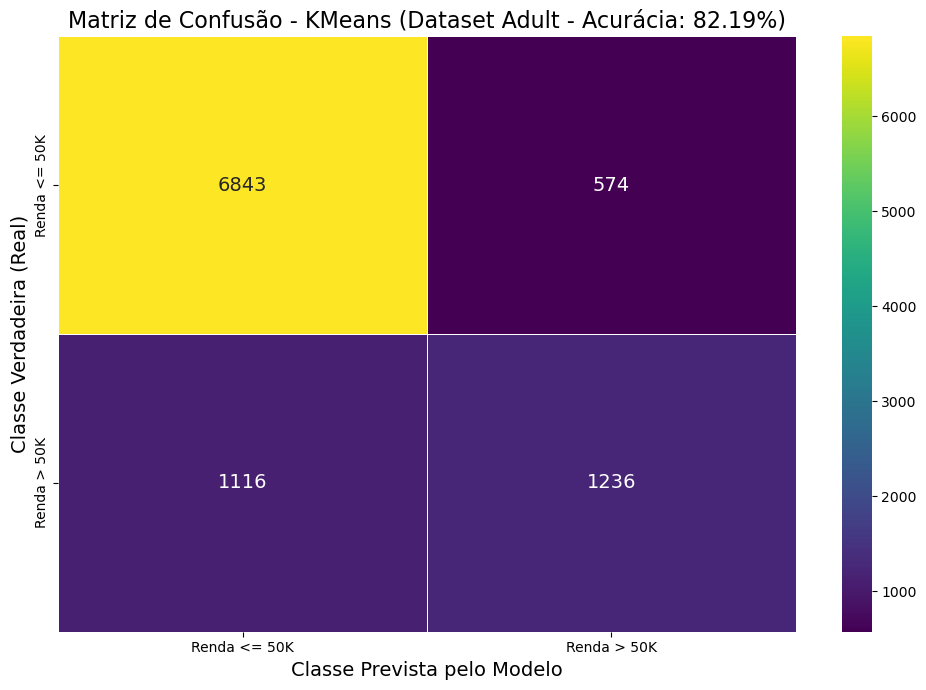

Gráfico salvo como: matriz_adult_original_fcm.png


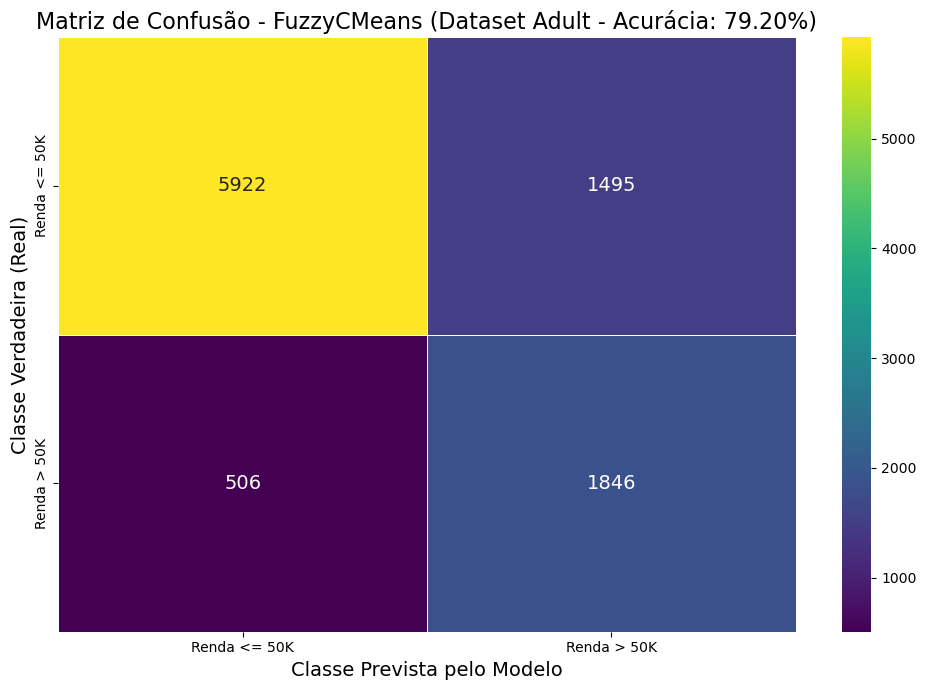

Gráfico salvo como: matriz_adult_original_gmm.png


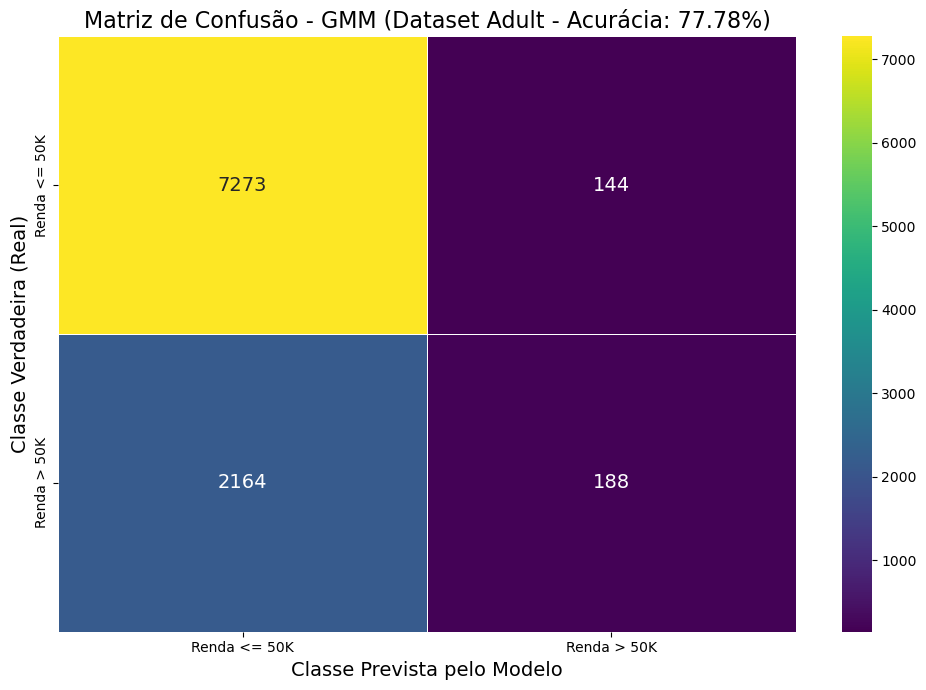


Processo finalizado. Todos os gráficos foram salvos na pasta.


In [17]:
# 1. Importa as bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 2. Função para plotar a matriz (nenhuma alteração necessária aqui)
def plotar_matriz_confusao(cm, classes, titulo, nome_arquivo):
    """
    Esta função plota a matriz de confusão e a salva como um arquivo de imagem.
    """
    plt.figure(figsize=(10, 7))
    
    sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), 
                annot=True,
                fmt='d',
                cmap='viridis', # Mudei a cor para diferenciar
                linewidths=.5,
                annot_kws={"size": 14})

    plt.title(titulo, fontsize=16)
    plt.ylabel('Classe Verdadeira (Real)', fontsize=14)
    plt.xlabel('Classe Prevista pelo Modelo', fontsize=14)
    plt.tight_layout()
    
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_arquivo}")
    plt.show()
    plt.close()


# --------------------------------------------------------------------------
# <<<<< DADOS DE ENTRADA ATUALIZADOS COM SEUS NOVOS RESULTADOS >>>>>
# --------------------------------------------------------------------------

# Os nomes das classes para o dataset Adult
classes_adult = ['Renda <= 50K', 'Renda > 50K']

# 1. Resultados para o KMeansClassifier (Acurácia: 82.19%)
matriz_adult_kmeans = np.array([
    [6843,  574],
    [1116, 1236]
])
titulo_adult_kmeans = 'Matriz de Confusão - KMeans (Dataset Adult - Acurácia: 82.19%)'
nome_arquivo_adult_kmeans = 'matriz_adult_original_kmeans.png'

# 2. Resultados para o FuzzyCMeansClassifier (Acurácia: 79.20%)
matriz_adult_fcm = np.array([
    [5922, 1495],
    [ 506, 1846]
])
titulo_adult_fcm = 'Matriz de Confusão - FuzzyCMeans (Dataset Adult - Acurácia: 79.20%)'
nome_arquivo_adult_fcm = 'matriz_adult_original_fcm.png'

# 3. Resultados para o GMMClassifier (Acurácia: 77.78%)
matriz_adult_gmm = np.array([
    [7273,  144],
    [2164,  188]
])
titulo_adult_gmm = 'Matriz de Confusão - GMM (Dataset Adult - Acurácia: 77.78%)'
nome_arquivo_adult_gmm = 'matriz_adult_original_gmm.png'


# --------------------------------------------------------------------------
# Chamada das funções para gerar e SALVAR cada gráfico
# --------------------------------------------------------------------------

print("Gerando e salvando os gráficos com os resultados finais...")

plotar_matriz_confusao(matriz_adult_kmeans, classes_adult, titulo_adult_kmeans, nome_arquivo_adult_kmeans)
plotar_matriz_confusao(matriz_adult_fcm, classes_adult, titulo_adult_fcm, nome_arquivo_adult_fcm)
plotar_matriz_confusao(matriz_adult_gmm, classes_adult, titulo_adult_gmm, nome_arquivo_adult_gmm)

print("\nProcesso finalizado. Todos os gráficos foram salvos na pasta.")

In [3]:
# Importações completas
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from kneed import KneeLocator
import warnings
from scipy.spatial.distance import cdist

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Função de pré-processamento (sem alterações)
def load_and_process_original_adult(file_path):
    # ... (código da função como estava antes) ...
    try:
        column_names = [
            'age', 'workclass', 'fnlwgt', 'education', 'education-num',
            'marital-status', 'occupation', 'relationship', 'race', 'sex',
            'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
        ]
        df = pd.read_csv(file_path, header=None, names=column_names, 
                         na_values=' ?', skipinitialspace=True)
        df.dropna(inplace=True)
        X = df.drop('income', axis=1)
        y_raw = df['income']
        le = LabelEncoder()
        y = le.fit_transform(y_raw)
        numeric_features = X.select_dtypes(include=np.number).columns.tolist()
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        numeric_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])
        return X, y, preprocessor, le.classes_
    except FileNotFoundError:
        return None, None, None, None

# Função find_optimal_k (sem alterações, mas já corrigida)
def find_optimal_k(data, max_k=10):
    if data.shape[0] < max_k: max_k = data.shape[0]
    if max_k <= 1: return 1
    inertias = []
    k_range = range(1, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(data)
        inertias.append(kmeans.inertia_)
    try:
        kneedle = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
        return kneedle.elbow if kneedle.elbow else 2
    except:
        return 2

# --- Classes dos Classificadores ATUALIZADAS E CORRIGIDAS ---
class KMeansClassifier:
    def __init__(self):
        self.centroids_ = []
        self.centroid_labels_ = [] # Correto: inicializado como lista
        self.k_per_class_ = {}

    def fit(self, X_train, y_train):
        self.centroids_ = []
        self.centroid_labels_ = [] # <-- CORREÇÃO AQUI: de {} para []
        self.k_per_class_ = {}
        unique_classes = np.unique(y_train)

        for c in unique_classes:
            X_class = X_train[y_train == c]
            if X_class.shape[0] > 0:
                # É mais estável rodar o find_optimal_k em array denso
                optimal_k = find_optimal_k(X_class.toarray())
                self.k_per_class_[c] = optimal_k
                
                kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(X_class)
                self.centroids_.extend(kmeans.cluster_centers_)
                self.centroid_labels_.extend([c] * optimal_k)
        return self

    def predict(self, X_test):
        if not self.centroids_:
            raise RuntimeError("O classificador deve ser treinado antes da predição.")
        distances = cdist(X_test.toarray(), self.centroids_)
        closest_centroid_indices = np.argmin(distances, axis=1)
        return np.array(self.centroid_labels_)[closest_centroid_indices]

class FuzzyCMeansClassifier:
    def __init__(self, m=2):
        self.centroids_ = []
        self.centroid_labels_ = [] # Correto: inicializado como lista
        self.m_ = m
        self.k_per_class_ = {}

    def fit(self, X_train, y_train):
        self.centroids_ = []
        self.centroid_labels_ = [] # <-- CORREÇÃO AQUI: de {} para []
        self.k_per_class_ = {}
        unique_classes = np.unique(y_train)

        for c in unique_classes:
            X_class = X_train[y_train == c]
            if X_class.shape[0] > 1:
                X_class_dense = X_class.toarray()
                optimal_k = find_optimal_k(X_class_dense)
                self.k_per_class_[c] = optimal_k
                
                cntr, _, _, _, _, _, _ = fuzz.cluster.cmeans(
                    X_class_dense.T, c=optimal_k, m=self.m_, error=0.005, maxiter=1000, init=None
                )
                self.centroids_.extend(cntr)
                self.centroid_labels_.extend([c] * optimal_k)
        return self

    def predict(self, X_test):
        if not self.centroids_:
            raise RuntimeError("O classificador deve ser treinado antes da predição.")
        u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            X_test.toarray().T, np.array(self.centroids_), self.m_, error=0.005, maxiter=1000
        )
        max_membership_indices = np.argmax(u, axis=0)
        return np.array(self.centroid_labels_)[max_membership_indices]

# A classe GMMClassifier não precisava de correção, mas a incluo para manter a consistência
class GMMClassifier:
    def __init__(self):
        self.gmms_ = {}
        self.classes_ = []
        self.k_per_class_ = {}
    def fit(self, X_train, y_train):
        self.gmms_ = {}
        self.classes_ = np.unique(y_train)
        self.k_per_class_ = {}
        for c in self.classes_:
            X_class = X_train[y_train == c]
            if X_class.shape[0] > 1:
                X_class_dense = X_class.toarray()
                optimal_k = find_optimal_k(X_class_dense)
                self.k_per_class_[c] = optimal_k
                gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(X_class_dense)
                self.gmms_[c] = gmm
        return self
    def predict(self, X_test):
        if not self.gmms_: raise RuntimeError("O classificador deve ser treinado antes da predição.")
        log_likelihoods = np.array([self.gmms_[c].score_samples(X_test.toarray()) for c in self.classes_])
        return self.classes_[np.argmax(log_likelihoods, axis=0)]

# --- Função de Experimento ATUALIZADA ---
def run_experiment_original(classifier_class, file_path, n_repetitions=30):
    X_raw, y, preprocessor, original_classes = load_and_process_original_adult(file_path)
    if X_raw is None: return
    accuracies = []
    print(f"\n--- Iniciando Experimento com Base Original: {classifier_class.__name__} ---")
    for i in range(n_repetitions):
        seed = i + 1
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X_raw, y, test_size=0.3, random_state=seed, stratify=y, shuffle=True
        )
        preprocessor.fit(X_train_raw)
        X_train = preprocessor.transform(X_train_raw)
        X_test = preprocessor.transform(X_test_raw)
        classifier = classifier_class()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        if (i + 1) % 5 == 0 or i == n_repetitions - 1:
            print(f"Repetição {i + 1}/{n_repetitions}: Acurácia = {acc:.4f}")
    
    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)
    
    print("\n--- Resultados Finais ---")
    print(f"Acurácia Média ({n_repetitions} repetições): {mean_accuracy:.4f}")
    print(f"Desvio Padrão da Acurácia: {std_dev_accuracy:.4f}")
    
    print("\nMatriz de Confusão (da última repetição):")
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(original_classes)))
    cm_df = pd.DataFrame(cm, index=original_classes, columns=original_classes)
    print(cm_df)
    
    # --- BLOCO NOVO PARA EXIBIR O NÚMERO DE CLUSTERS ---
    print("\nNúmero de Clusters Usado por Classe (na última repetição):")
    if hasattr(classifier, 'k_per_class_'):
        for class_idx, k_value in sorted(classifier.k_per_class_.items()):
            class_name = original_classes[class_idx]
            print(f"  - Classe '{class_name}': {k_value} clusters")
    print("--------------------------------------------------\n")

# --- Execução do Experimento ---
ADULT_CSV_PATH = 'adult2.csv'
classifiers_to_test = [KMeansClassifier, FuzzyCMeansClassifier, GMMClassifier]

print("#############################################")
print("### INICIANDO ANÁLISE PARA O DATASET ADULT ORIGINAL ###")
print("#############################################")
for clf in classifiers_to_test:
    run_experiment_original(clf, ADULT_CSV_PATH, n_repetitions=30)

#############################################
### INICIANDO ANÁLISE PARA O DATASET ADULT ORIGINAL ###
#############################################

--- Iniciando Experimento com Base Original: KMeansClassifier ---
Repetição 5/30: Acurácia = 0.8225
Repetição 10/30: Acurácia = 0.8277
Repetição 15/30: Acurácia = 0.8082
Repetição 20/30: Acurácia = 0.8181
Repetição 25/30: Acurácia = 0.8217
Repetição 30/30: Acurácia = 0.8270

--- Resultados Finais ---
Acurácia Média (30 repetições): 0.8219
Desvio Padrão da Acurácia: 0.0052

Matriz de Confusão (da última repetição):
       <=50K  >50K
<=50K   6843   574
>50K    1116  1236

Número de Clusters Usado por Classe (na última repetição):
  - Classe '<=50K': 5 clusters
  - Classe '>50K': 3 clusters
--------------------------------------------------


--- Iniciando Experimento com Base Original: FuzzyCMeansClassifier ---
Repetição 5/30: Acurácia = 0.7925
Repetição 10/30: Acurácia = 0.7929
Repetição 15/30: Acurácia = 0.7945
Repetição 20/30: Acurácia =